## AutoEncoder

In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance

### 개요
- 목적 : 10일 수익률을 입력값으로 넣었을 때 비슷한 패턴 구현할 수 있는 알고리즘 만들기
    - window 길이 : 10
    - 예측값 : 10개 로그 수익률 입력으로 넣었을 때 얻는 10개 로그 수익률
- 입력 데이터에 대해 최소 - 최대 정규화 진행

## 1. Raw Data

In [4]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

nasdaq=pdr.get_data_yahoo('^IXIC', '1999-12-31')
kosdaq = pdr.get_data_yahoo('^KQ11', '1999-12-31')

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [35]:
nasdaq.head(10)

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_ret
Date,,,,,,,,
1999-12-31,4056.989990,4082.370117,4032.330078,4069.310059,4069.310059,762980000,NaN,NaN
2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000,0.015197,0.015082
2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000,-0.055544,-0.057146
2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000,-0.006190,-0.006209
2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000,-0.038790,-0.039562
2000-01-07,3711.090088,3882.669922,3711.090088,3882.620117,3882.620117,1634930000,0.041718,0.040872
2000-01-10,4002.229980,4072.360107,3958.830078,4049.669922,4049.669922,1691710000,0.043025,0.042125
2000-01-11,4031.379883,4066.659912,3904.820068,3921.189941,3921.189941,1694460000,-0.031726,-0.032240
2000-01-12,3950.949951,3950.979980,3834.530029,3850.020020,3850.020020,1525900000,-0.018150,-0.018317


In [63]:
a = nasdaq.iloc[6:, -2:]

### 2. 로그 수익률 데이터 가공

In [37]:
window_length = 5
encoding_dim = 2
epochs = 100
test_samples = 200

import pandas as pd

nasdaq['pct_change'] = nasdaq['Adj Close'].pct_change()
nasdaq['log_ret'] = np.log(nasdaq['Adj Close']) - np.log(nasdaq['Adj Close'].shift(1))

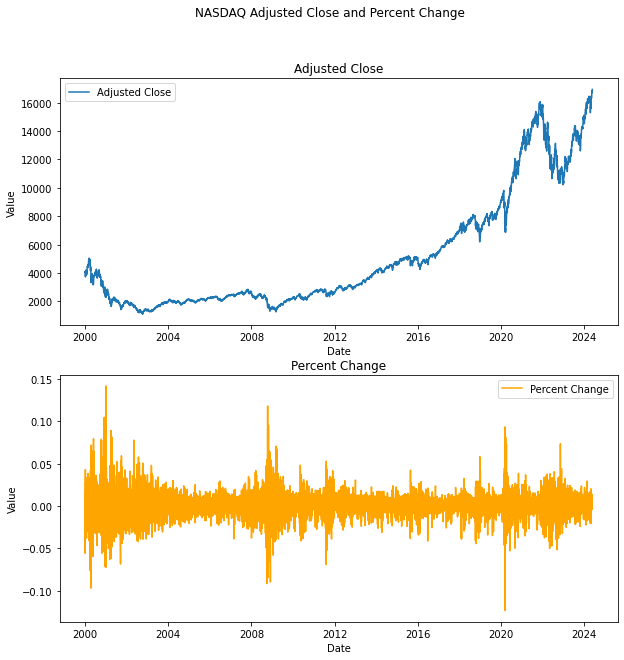

In [38]:
plt.figure(figsize = (10,10))
plt.suptitle('NASDAQ Adjusted Close and Percent Change')

# First subplot for Adjusted Close
plt.subplot(2, 1, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(nasdaq['Adj Close'], label='Adjusted Close')
plt.title('Adjusted Close')  # Title for the first subplot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()  

# Second subplot for Percent Change
plt.subplot(2, 1, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(nasdaq['pct_change'], label='Percent Change', color='orange')
plt.title('Percent Change')  # Title for the second subplot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()  


plt.show()

- (종가 - 전일 종가)로 로그 수익률 계산
- 로그 함수 성질 이용

In [39]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [40]:
scaler = MinMaxScaler()
x_train = np.array([scaler.fit_transform(nasdaq['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in range(window_length+1,len(nasdaq['log_ret']))])
x_train = x_train[:-test_samples]
x_test = x_train[-test_samples:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("테스트 데이터 비중: {}%".format((test_samples/len(x_train))*100))

테스트 데이터 비중: 3.3709758975223325%


In [41]:
x_train.shape

(5933, 5, 1)

In [42]:
x_test.shape

(200, 5, 1)

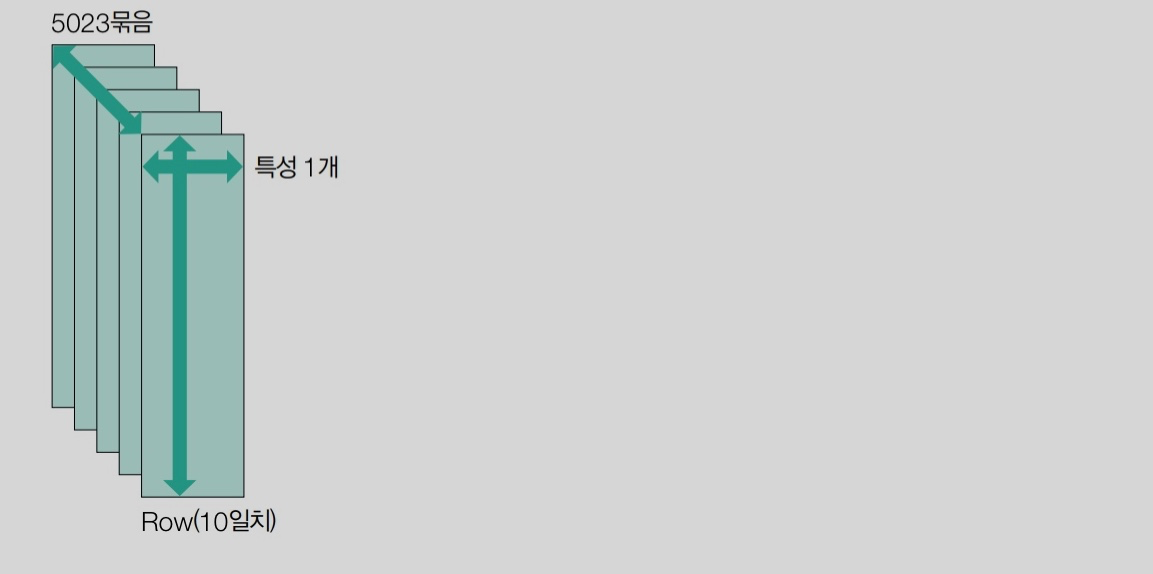

### 첫 번째 모델 : 단순 MLP 오토인코더
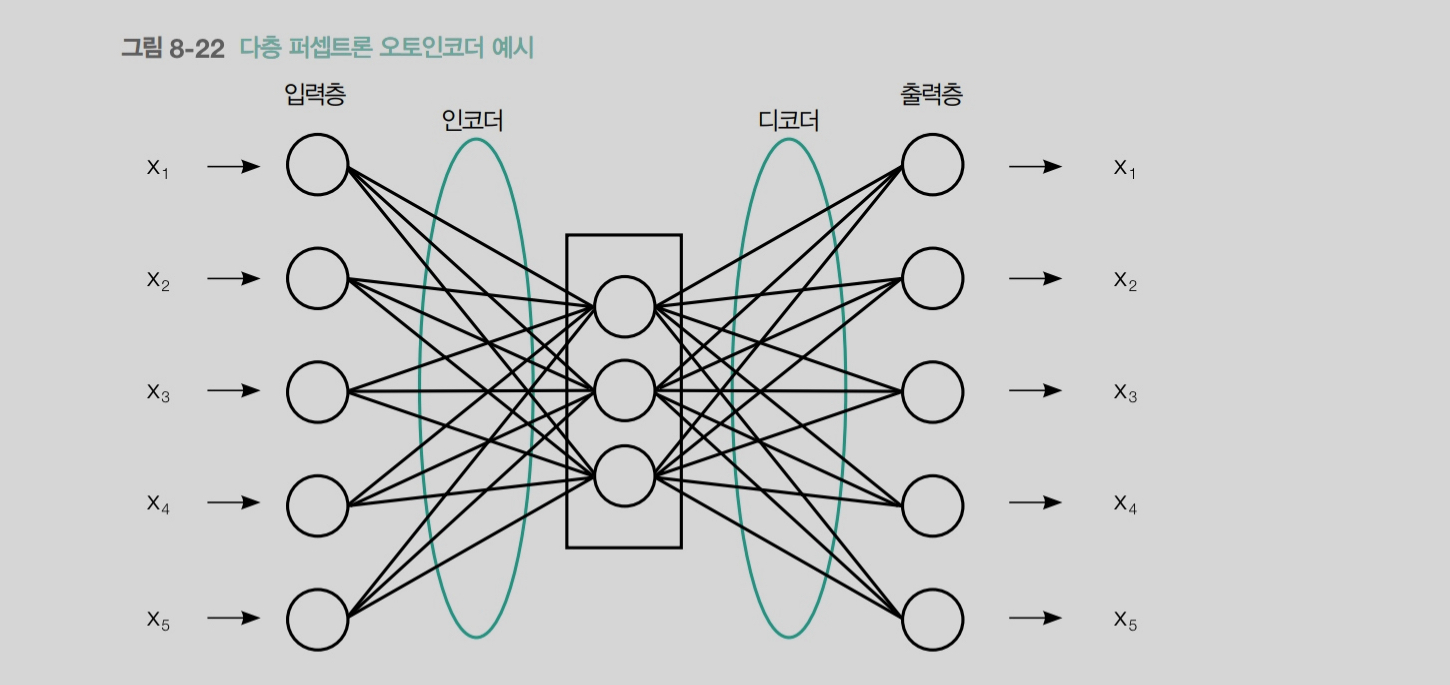

- 입력 받는 10개 데이터에 10개 출력이 3개 압축층 통과하고 출력층에 10개 출력을 보냄
- 각 모델 손실값 변화에 대해, 테스트 데이터로 오토인코더 예측값 출력하여 비교

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 21ms/step - loss: 0.7233 - val_loss: 0.7199
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7209 - val_loss: 0.7176
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7186 - val_loss: 0.7153
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7164 - val_loss: 0.7133
Epo

6/6 [==============================] - 0s 5ms/step - loss: 0.6364 - val_loss: 0.6348
Epoch 78/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6354 - val_loss: 0.6339
Epoch 79/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6345 - val_loss: 0.6330
Epoch 80/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6335 - val_loss: 0.6320
Epoch 81/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6326 - val_loss: 0.6311
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6316 - val_loss: 0.6302
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6307 - val_loss: 0.6293
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6297 - val_loss: 0.6283
Epoch 85/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6288 - val_loss: 0.6274
Epoch 86/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6279 - val_loss: 0.6265
Epoch 87/100
6/6 [===============

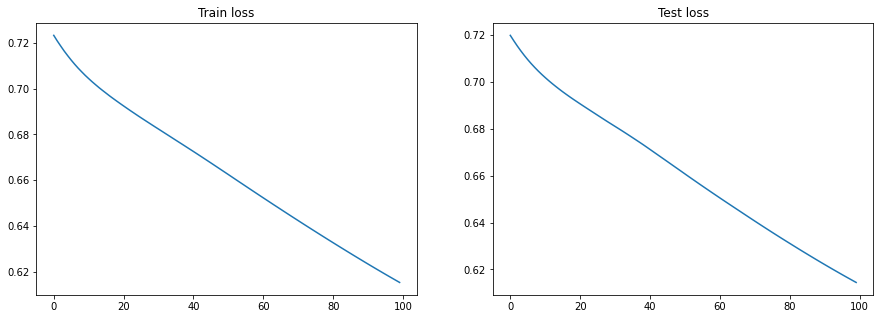

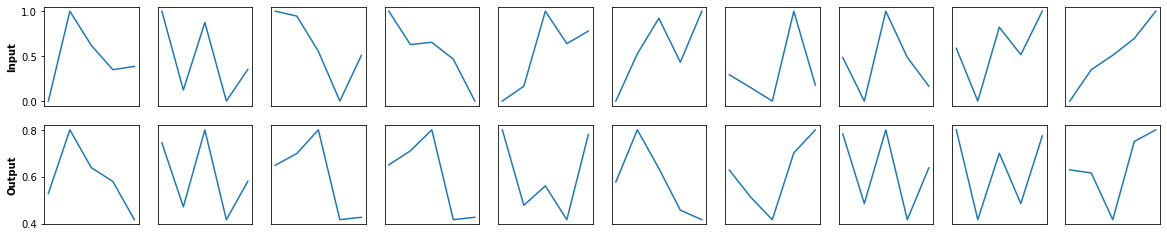

In [43]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
# "encoded"는 input데이터를 encode로 압축한다.
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded"는 압축된 데이터로 input 데이터를 최대한 표현한다.
decoded = Dense(window_length, activation='sigmoid')(encoded)

# 2개의 모델이 있다.
# 하나는 인풋데이터를 인코더 디코더를 통해 인풋값을 예측하는 모델.
autoencoder = Model(input_window, decoded)
# 다른 하나는 인풋데이터를 인코더 디코더로 압축하는 모델.
encoder = Model(input_window, encoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

### 두 번째 : Deep 오토인코더

- 다층 퍼셉트론 모델에 배치층 추가한 구조
- 인코더 + 차원 축소층, 디코더 + 차원 확장층 
- 공통적으로 배치정규화층 추가 구성

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 36        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 14        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 18        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 35 

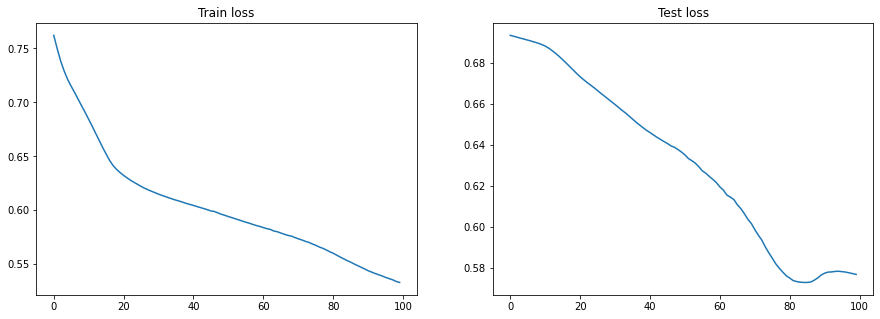

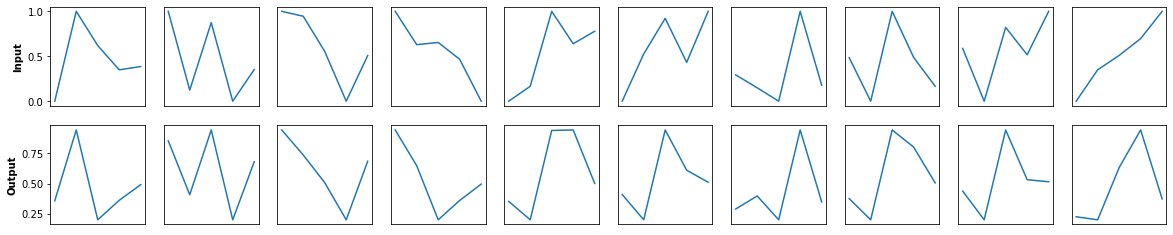

In [44]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x) # 입력값 정규화
encoded = Dense(encoding_dim, activation='relu')(x) 
# 완전 연결층 정의하면서 encoding 차원으로 축소 전달
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded) # 3차원 -> 6차원
x = BatchNormalization()(x) # 입력값 정규화
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

- 100번 에폭 동안 손실값 꾸준히 감소
- 입력값 예측값 : 상승과 하락 재현한 부분 몇 군데 있

## 1D Convolutional autoencoder


In [45]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)
plot_history(history)
plot_examples(x_test, decoded_stocks)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 16)             64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3, 1)              49        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 1)              0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 1)              4         
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 4, 1)              0  

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 6, 1) vs (None, 5, 1))


## LSTM(recurrent neural networks) autoencoder

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 32        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 2)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 1)              16        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 3s 129ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 3/100
6/6 [==============================] - 0s 7ms/step -

Epoch 76/100
6/6 [==============================] - 0s 7ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 77/100
6/6 [==============================] - 0s 7ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 78/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 79/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 80/100
6/6 [==============================] - 0s 7ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 81/100
6/6 [==============================] - 0s 7ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 82/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 83/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 84/100
6/6 [==============================] - 0s 7ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 85/100
6/6 [==============================] - 0s 8ms/step - loss: 7.6844 - val_loss: 7.4594
Epoch 86/100
6/6 [==

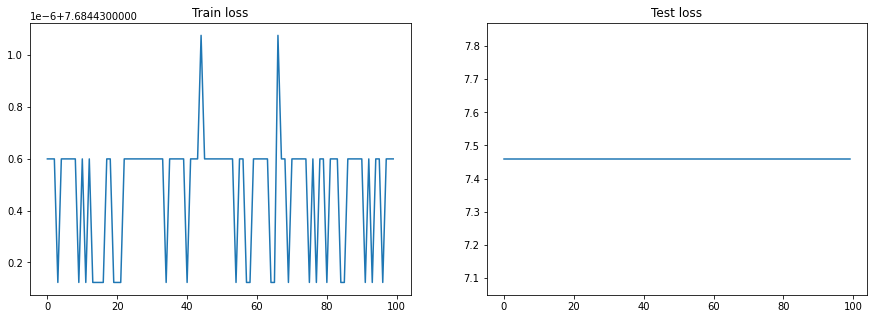

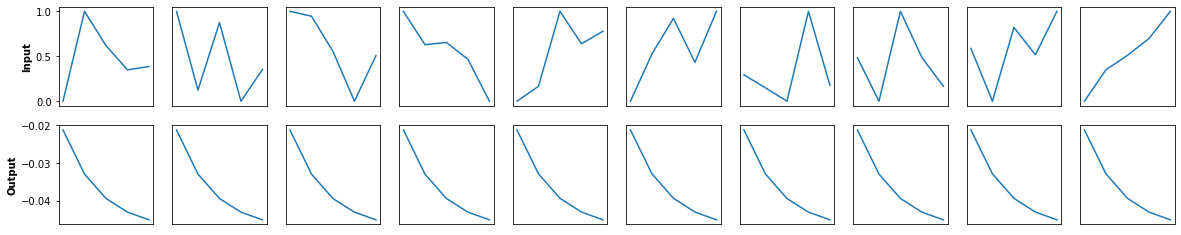

In [46]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)
plot_history(history)
plot_examples(x_test, decoded_stocks)

Epoch 1/100
6/6 [==============================] - 3s 119ms/step - loss: 0.4514 - val_loss: 0.3610
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3587 - val_loss: 0.3493
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3440 - val_loss: 0.3323
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3399 - val_loss: 0.3258
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3299 - val_loss: 0.3225
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3248 - val_loss: 0.3139
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3191 - val_loss: 0.3089
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3132 - val_loss: 0.3043
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3092 - val_loss: 0.3003
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3035 - val_loss: 0.2951
Epoch 11/100
6/6 [

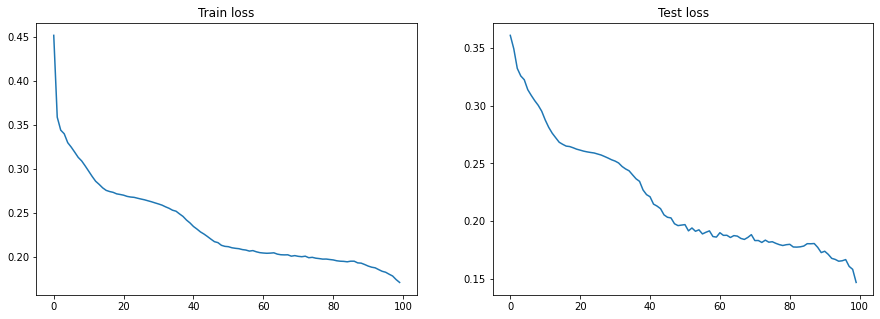

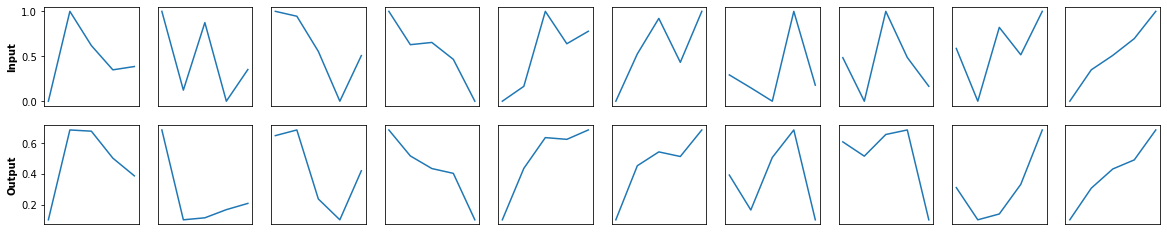

In [48]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dropout
# from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout, RepeatVector, TimeDistributed


window_length = 5
encoding_dim = 2
epochs = 100
test_samples = 200


model = Sequential([
    LSTM(128, input_shape=(window_length, 1)),
    Dropout(0.3),
    RepeatVector(window_length),
    LSTM(128, return_sequences=True), 
    Dropout(0.3),
    TimeDistributed(Dense(1))
])


model.compile(optimizer='adam', loss='mae')
history = model.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = model.predict(x_test)
plot_history(history)
plot_examples(x_test, decoded_stocks)

## Encoder를 Feature로 활용하기

- 인코더 모델에서 predict() 함수 호출하여 출력된 값을 새로운 특성 데이터로 사용
- 입력 데이터층은 오토인코더와 동일하지만 출력층이 encoded 층임

In [49]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)

autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple) 
# 출력된 값 새로운 특성 데이터로 사용

#############
compress_x_train = encoder.predict(x_train_simple)
# 학습 데이터를 인코더 모델에 전달해 압축된 출력값 생성
compress_x_test = encoder.predict(x_test_simple)
# 테스트 데이터를 인코더 모델에 전달해 압축된 출력값 생성

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 21ms/step - loss: 0.7146 - val_loss: 0.7022
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7108 - val_loss: 0.6988
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7073 - val_loss: 0.6957
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7039 - val_loss: 0.6926
Epo

6/6 [==============================] - 0s 5ms/step - loss: 0.6124 - val_loss: 0.6067
Epoch 78/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6117 - val_loss: 0.6060
Epoch 79/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6110 - val_loss: 0.6053
Epoch 80/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6102 - val_loss: 0.6046
Epoch 81/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6095 - val_loss: 0.6039
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6088 - val_loss: 0.6032
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6081 - val_loss: 0.6025
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6075 - val_loss: 0.6019
Epoch 85/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6068 - val_loss: 0.6012
Epoch 86/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6061 - val_loss: 0.6006
Epoch 87/100
6/6 [===============

In [50]:
x_train_simple.shape
# 압축되기 전 10차원

(5933, 5)

In [51]:
compress_x_train.shape
# 압축된 새로운 특성 데이터 3차원

(5933, 2)

In [52]:
compress_x_test.shape

(200, 2)

In [54]:
# 압축된 Feature 데이터를 입력값으로 전달

new_feature = np.concatenate([compress_x_train,compress_x_test])
tmp_df = pd.DataFrame(new_feature,columns=['comp_fe1','comp_fe2'])

In [55]:
tmp_df

,comp_fe1,comp_fe2
0,0.618603,0.422928
1,1.811931,0.525239
2,0.161636,0.000000
3,0.000000,0.996170
4,1.110866,2.010788
...,...,...
6128,0.000000,1.135982
6129,0.178245,1.292992
6130,1.782091,1.368582
6131,0.792279,0.099597


In [56]:
len(a)

6139

In [67]:
a.reset_index(inplace=True)

In [70]:
a = a.join(tmp_df,how='left').set_index('Date')

In [72]:
a.to_csv('/aiffel/aiffel/0000/MLStock/Data/nasdaq.csv')

In [ ]:
sp = pdr.get_data_yahoo('^GSPC', '1999-12-31')
snp500_df = pd.DataFrame({'Adj Close':sp['Adj Close']})
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change()
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1))